# PyTorch Faster R-CNN

This is a basic pipeline for pedestrian detection using Faster R-CNN with resnet50 backbone, pretrained on COCO dataset, using PyTorch by following this tutorial [https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html]. 

Currently trained the heads using only 234 images from Hamburg (from Cityscapes dataset) and annotations (ground truths) from Citypersons dataset. Split: 50 images for test set and $234 - 50$ images for train set.

TODO:
1. Train on complete train set (whole `anno_train.mat`). 
2. Evaluate on the test set (`anno_val.mat`).
    1. Prepare detection results in COCO format, and write them in a single .json file.
    2. Run eval_demo.py from Citypersons GitHub; see [https://github.com/cvgroup-njust/CityPersons/tree/master/evaluation/eval_script/?at=default].
    3. Detailed evaluations will be written to results.txt.

## Setup

### Dependencies

Tested using torch.__version__ = 1.8.0. To install other dependencies run:

```bash
$ pip install --upgrade pip
$ pip install torchvision
$ pip install cython
$ pip install pycocotools
$ pip install torch-summary
```

### Helper functions

We will import some helper functions to simplify training and evaluating detection model. We will use `/references/detection/{engine, utils, transforms}.py` from `pytorch.vision` repository:

```bash
$ git clone https://github.com/pytorch/vision.git
$ mkdir pytorch-helpers
$ cd vision
$ git checkout v0.3.0
$ cp references/detection/utils.py ../pytorch-helpers/
$ cp references/detection/transforms.py ../pytorch-helpers/
$ cp references/detection/coco_eval.py ../pytorch-helpers/
$ cp references/detection/engine.py ../pytorch-helpers/
$ cp references/detection/coco_utils.py ../pytorch-helpers/
$ cd ../pytorch-helpers/
$ chmod +x *
```

### Imports

In [1]:
import scipy.io
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import sys
import os

import torch
import torch.utils.data

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [2]:
# ../src/pytorch-helpers/
module_path = os.path.abspath(os.path.join('../src/pytorch-helpers/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from engine import train_one_epoch, evaluate
import utils
import transforms as T

## Data

To get the data first download the images from our data server. Let's download only Hamburg images to hamburg directory:
```bash
$ mkdir hamburg # from project's root directory
$ cd hamburg
$ scp user1@159.89.9.230:/home/user1/cityscapes-dataset/leftImg8bit/train/hamburg/* .
$ cd ..
```

To get annotations from Citypersons dataset, clone their GitHub repository:
```bash
$ git clone https://github.com/cvgroup-njust/CityPersons.git
```

Let's save the image path and annotations path:

In [3]:
img_path = '/home/marko/data/cityscapes/leftImg8bit_trainvaltest/leftImg8bit/train/hamburg/'
anno_path = '/home/marko/data/citypersons/'

In [4]:
def get_annotations(anno_path, anno_val=False):
    ''' Prepares data - only train data for now, by
    transforming annotations from .mat format to a dictionary.
    '''
    
    if anno_val:
        anno_train = scipy.io.loadmat(anno_path + 'anno_val.mat')
        anno_train = anno_train['anno_val_aligned']        
    else:
        anno_train = scipy.io.loadmat(anno_path + 'anno_train.mat')
        anno_train = anno_train['anno_train_aligned']

    d = {}
    for i in range(anno_train[0].shape[0]):
        # extract data from the annotations matrix
        city_name = anno_train[0, i][0][0][0][0]
        img_name = anno_train[0, i][0][0][1][0]

        bboxes = []
        for bb in anno_train[0, i][0][0][2]:
            if bb[0] > 0: # class_label = 1 means it is a person
                bboxes.append(bb[1:5]) # bbox format = [x, y, w, h]
        
        ## keep only images with persons
        if bboxes != []:
            d[img_name] = bboxes
    
    return d

In [5]:
anno_dict_val = get_annotations(anno_path, anno_val=True)

In [6]:
len(list(anno_dict_val.keys()))

441

In [8]:
# np.save(file='../data/anno-val.npy', arr=anno_dict_val)
# np.save(file='../data/anno-all.npy', arr=anno_dict)

In [9]:
anno_dict = get_annotations(anno_path)

In [10]:
len(list(anno_dict.keys()))

2500

In [11]:
anno_dict['aachen_000000_000019_leftImg8bit.png']

[array([892, 445,  21,  53], dtype=uint16),
 array([901, 443,  34,  55], dtype=uint16),
 array([1844,  436,   44,  106], dtype=uint16)]

In [22]:
#imgs = list(anno_dict.keys())
imgs = os.listdir(img_path) # only Hamburg
imgs[:5]

['hamburg_000000_021961_leftImg8bit.png',
 'hamburg_000000_066424_leftImg8bit.png',
 'hamburg_000000_098061_leftImg8bit.png',
 'hamburg_000000_039264_leftImg8bit.png',
 'hamburg_000000_099902_leftImg8bit.png']

In [53]:

H, W

(1024, 2048)

In [71]:
def show(img_path, img_name, anno_dict):
    '''Shows the image and corresponding annotations.'''
    
    img = Image.open(img_path + img_name)
    bboxes = anno_dict[img_name]

    plt.rcParams['figure.figsize'] = [12, 8]

    fig, ax = plt.subplots()
    ax.imshow(img);

    # bbox = [x, y, w, h]
    for bbox in bboxes:
        rect = patches.Rectangle(
            (bbox[0], bbox[1]), bbox[2], bbox[3], 
            linewidth=1, edgecolor='r', facecolor='none')

        ax.add_patch(rect)

    plt.title('Example image from Hamburg')
    plt.show()

## Check data

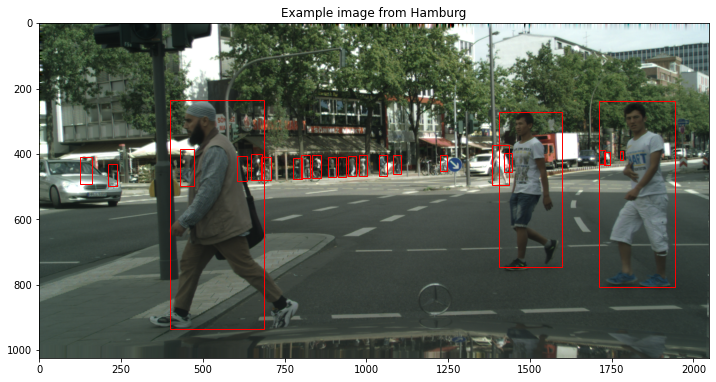

In [72]:
i = 20 # 16, 20
show(img_path, imgs[i], anno_dict)

Tiny persons?

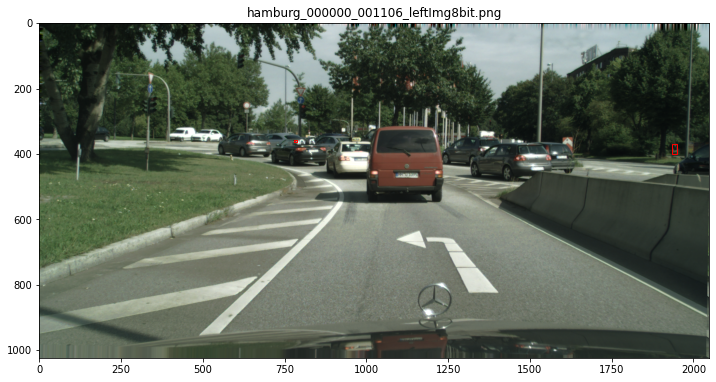

In [64]:
show(img_path, imgs[1], anno_dict)

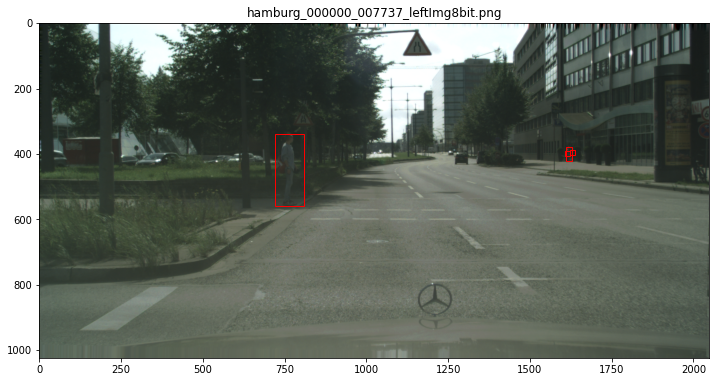

In [65]:
show(img_path, imgs[11], anno_dict)

TODO: Take a cutoff of 10x10 again as in `AnchorBoxes.ipynb`

## Prepare Torch.utils.data.Dataset class for this dataset

In [66]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, root, anno_dict, transforms=None):
        '''
        root: img_path: directory of images)
        anno_dict: annotations
        '''
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(root)))
        self.anno = anno_dict
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root, self.imgs[idx])
        img = Image.open(img_path).convert('RGB')
        
        ## prepare bboxes coordinates 
        # transform from [x, y, w, h] to [x0, y0, x1, y1]
        boxes = []
        for bbox in self.anno[self.imgs[idx]]:
            x, y = bbox[0], bbox[1]
            w, h = bbox[2], bbox[3]
            boxes.append([x, y, x+w, y+h])
        
        # transform to torch tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        ## define labels, there is only one class
        num_objs = len(boxes)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        
        ## other definitions
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd        
        
        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target        
        
    def __len__(self):
        return len(self.imgs)

In [67]:
dataset = Dataset(img_path, anno_dict)

In [68]:
dataset[0]

(<PIL.Image.Image image mode=RGB size=2048x1024 at 0x7F6D4B563400>,
 {'boxes': tensor([[ 682.,  401.,  695.,  434.],
          [ 202.,  418.,  222.,  468.],
          [ 166.,  403.,  196.,  474.],
          [1343.,  369., 1349.,  384.],
          [1637.,  352., 1667.,  425.],
          [1826.,  308., 1888.,  458.],
          [1867.,  291., 1936.,  459.],
          [1469.,  352., 1500.,  428.],
          [ 759.,  394.,  771.,  422.],
          [1259.,  369., 1268.,  390.]]),
  'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
  'image_id': tensor([0]),
  'area': tensor([  429.,  1000.,  2130.,    90.,  2190.,  9300., 11592.,  2356.,   336.,
            189.]),
  'iscrowd': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])})

## Define the model

In [69]:
def get_model():
    # load a model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # replace the classifier with a new one, that has
    # num_classes which is user-defined
    num_classes = 2  # 1 class (person) + background
    
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)     
    
    return model

## Train the model

In [70]:
def get_transform(train):
    ''' Converts the image, a PIL image, into a PyTorch Tensor. '''
    
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
        
    return T.Compose(transforms)

We do not need to add a mean/std normalization nor image rescaling in the data transforms, as those are handled internally by the Faster R-CNN model.

In [72]:
## split the dataset into train and test
dataset = Dataset(img_path, anno_dict, get_transform(train=True))
dataset_test = Dataset(img_path, anno_dict, get_transform(train=False))

## permute the indices
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
len(indices)

248

In [73]:
# train: 248 - 50 examples
# test: 50 examples
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

In [74]:
# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

In [75]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cpu')

In [77]:
model = get_model()
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [78]:
# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

In [79]:
# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

Let's train the model for 10 epochs, evaluating at the end of every epoch.

In [ ]:
num_epochs = 1

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [ 0/99]  eta: 0:23:53  lr: 0.000056  loss: 2.7994 (2.7994)  loss_classifier: 0.7482 (0.7482)  loss_box_reg: 0.7893 (0.7893)  loss_objectness: 0.6670 (0.6670)  loss_rpn_box_reg: 0.5950 (0.5950)  time: 14.4814  data: 0.6560  max mem: 0


***Trained for about half an hour on Nvidia Tesla K-80 GPU with 12GB memory, but only about 32% percent memory usage (3.84GB)!***

## Save or load the model

In [46]:
def save_model(model, path="./models/entire_model.pt"):
    torch.save(model, path)
    print('Model saved to ' + path)
    
def load_model(path="./models/entire_model.pt"):
    if torch.cuda.is_available():
        return torch.load(path)
    else:
        return torch.load(path, map_location=torch.device('cpu'))

In [47]:
model = load_model()

In [48]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

## Error Analysis

### Ground truth

Let's check the first image again. First, find the position of first image in dataset, since we applied a random permutation:

In [182]:
img_raw = Image.open(img_path + imgs[0])
anno_raw = anno_dict[imgs[0]]
anno_raw

[array([682, 401,  13,  33], dtype=uint16),
 array([202, 418,  20,  50], dtype=uint16),
 array([166, 403,  30,  71], dtype=uint16),
 array([1343,  369,    6,   15], dtype=uint16),
 array([1637,  352,   30,   73], dtype=uint16),
 array([1826,  308,   62,  150], dtype=uint16),
 array([1867,  291,   69,  168], dtype=uint16),
 array([1469,  352,   31,   76], dtype=uint16)]

Let's check the first image and annotations from the dataset:

In [183]:
idx = indices.index(0)
img, anno = dataset[idx]

Convert the image back to the raw format: 

* rescale it from $[0, 1]$ back to $[0, 255]$ range;
* flip the channels back to $[\text{height}, \text{width}, 3]$ format;
* convert from tensor to numpy array;
* convert from numpy array to PIL Image;
* we could also flip again horizontally if the image was augmented, then we need to flip the annotations also;

(We could also just use the original image)

In [186]:
def convert_back(img, img_raw):
    img = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
    img = np.array(img)
    print('img shape: %d x %d x %d' % img.shape)
    img = Image.fromarray(np.uint8(img)).convert('RGB')

    img_flipped = np.array(img.transpose(Image.FLIP_LEFT_RIGHT))
    img_raw = np.array(img_raw)
    img_was_flipped = np.sum(img_flipped.flatten() == img_raw.flatten()) == img_flipped.shape[0] * img_flipped.shape[1] * img_flipped.shape[2]
    print('Image was flipped: %r' % img_was_flipped)
    
    return img

In [187]:
img = convert_back(img, img_raw)

img shape: 1024 x 2048 x 3
Image was flipped: True


Convert annotations back to $[x, y, \text{width}, \text{height}]$ format:

In [188]:
anno = np.array(anno['boxes'])

bboxes = []
for bbox in anno:
    bbox = list(bbox)
    x0, y0 = bbox[0], bbox[1]
    x1, y1 = bbox[2], bbox[3]
    bboxes.append([x0, y0, x1 - x0, y1 - y0])

bboxes

[[1353.0, 401.0, 13.0, 33.0],
 [1826.0, 418.0, 20.0, 50.0],
 [1852.0, 403.0, 30.0, 71.0],
 [699.0, 369.0, 6.0, 15.0],
 [381.0, 352.0, 30.0, 73.0],
 [160.0, 308.0, 62.0, 150.0],
 [112.0, 291.0, 69.0, 168.0],
 [548.0, 352.0, 31.0, 76.0]]

Draw the image and ground truth annotations

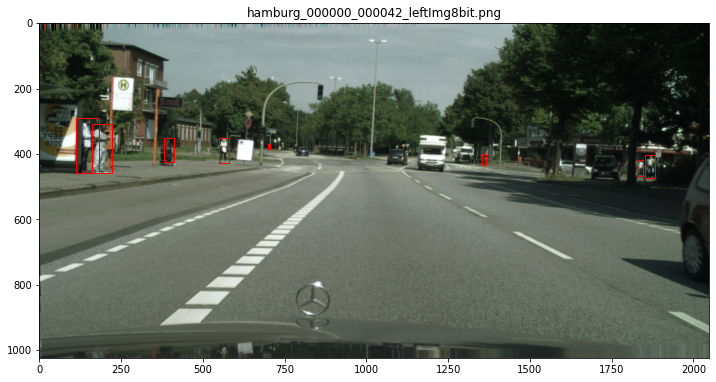

In [189]:
plt.rcParams['figure.figsize'] = [12, 8]
fig, ax = plt.subplots()
ax.imshow(img)

for bbox in bboxes:
    rect = patches.Rectangle(
        (bbox[0], bbox[1]), bbox[2], bbox[3], 
        linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

plt.title(img_name)
plt.show()

### Predicted

In [190]:
idx = indices.index(0)
img, anno = dataset[idx]

In [191]:
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]

In [175]:
preds = prediction['boxes'] # predicted bboxes
preds = preds.cpu().data.numpy() # to numpy array

In [192]:
scores = prediction['scores'] # scores of predicted bboxes
scores = scores.cpu().data.numpy()

Keep only bboxes where score > threshold:

In [193]:
threshold = .3
highs = list(np.where(scores > threshold)[0])

In [197]:
img = convert_back(img, img_raw)

img shape: 1024 x 2048 x 3
Image was flipped: False


Transform the bboxes from tensor to list and back to [x, y, w, h] format

In [198]:
bboxes_x0x1y0y1 = []
for high in highs:
    bboxes_x0x1y0y1.append(list(preds[high]))

In [199]:
# transform back to [x, y, w, h] format
bboxes = []
for bbox in bboxes_x0x1y0y1:
    bbox = list(bbox)
    x0, y0 = bbox[0], bbox[1]
    x1, y1 = bbox[2], bbox[3]

    bboxes.append([x0, y0, x1 - x0, y1 - y0])

In [200]:
bboxes

[[1867.6996, 290.07065, 67.795166, 167.83392],
 [1825.1581, 304.0287, 64.84131, 153.7576],
 [1470.5577, 350.14874, 29.113525, 76.17764],
 [164.02724, 403.86032, 27.321655, 70.52057],
 [1633.3987, 347.12476, 36.808716, 86.50476],
 [203.72154, 418.0811, 20.336884, 49.368347],
 [692.3051, 399.4909, 13.37677, 31.668182],
 [718.3954, 396.59528, 12.410156, 31.447906],
 [469.8653, 405.0747, 24.008911, 60.159637],
 [688.69385, 401.57434, 11.273804, 29.788849],
 [699.02216, 400.29993, 9.704529, 29.105682],
 [196.3171, 421.62366, 20.710953, 48.775146],
 [682.9064, 397.66486, 13.779358, 33.54306],
 [265.02777, 426.7236, 16.06134, 37.774017],
 [244.18729, 420.75235, 16.812256, 42.029114],
 [723.47906, 400.87936, 10.160645, 26.169312],
 [1020.65295, 389.33224, 10.42334, 24.94394],
 [715.3606, 399.43646, 11.354187, 28.690338]]

Draw the predicted bounding boxes

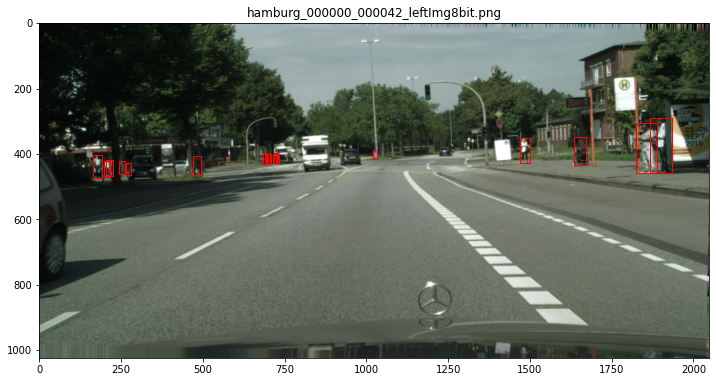

In [202]:
plt.rcParams['figure.figsize'] = [12, 8]

fig, ax = plt.subplots()

ax.imshow(img);

# bbox = [x, y, w, h]
for bbox in bboxes:
    rect = patches.Rectangle(
        (bbox[0], bbox[1]), bbox[2], bbox[3], 
        linewidth=1, edgecolor='r', facecolor='none')

    ax.add_patch(rect)

plt.title(img_name)
plt.show()